In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import random
import statsmodels.api as sm
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

msa_pop=pd.read_csv('msapop15.csv', encoding='cp1252')
ct_pop=pd.read_csv('ctpop15.csv', encoding='cp1252')

msa_income=pd.read_csv('msa_income2.csv', encoding='cp1252')
ct_income=pd.read_csv('ct_income.csv', encoding='cp1252')

In [2]:
ct_deciles = pd.read_csv('/Users/cateheine/Documents/SFI/CTScalingFiles/ct_deciles.csv')
ct_msa_key = ct_deciles[['msa','ct']]

msadf = pd.merge(msa_pop,msa_income,on='msa')
ctdf = pd.merge(ct_pop,ct_income,left_on='ct',right_on='tractid_census').drop('tractid_census',axis=1)
ctdf = pd.merge(ctdf, ct_msa_key, on='ct')

ctdf['total_workers'] = ctdf['total_workers'].astype(float)
ctdf['mean_dollars'] = ctdf['mean_dollars'].astype(float)
ctdf['total_dollars'] = ctdf['total_dollars'].astype(float)
ctdf['population'] = ctdf['population'].astype(float)
msadf['workers'] = msadf['workers'].astype(float)
msadf['meandollars'] = msadf['meandollars'].astype(float)
msadf['totaldollars'] = msadf['totaldollars'].astype(float)
msadf['population'] = msadf['population'].astype(float)


ctmsadf = pd.merge(ctdf,msadf,on='msa').rename(columns={'mean_dollars':'ct_meandollars','meandollars':'msa_meandollars','population_x':'ct_population','population_y':'msa_population','total_dollars':'ct_totaldollars','totaldollars':'msa_totaldollars','total_workers':'ct_workers','workers':'msa_workers'})

msadf_sum = ctdf.groupby('msa').agg({'population':'sum','total_dollars':'sum'}).reset_index().rename(columns={'population':'pop_sum','total_dollars':'dollars_sum'})
ctmsadf = ctmsadf.merge(msadf_sum,on='msa')

In [44]:
def create_ct(n,meaninc,sigma,sampling_rate):
    ct_meaninc = meaninc#int(random.choices(ct_income.mean_dollars, k=1)[0])
    ct_pop = n#int(random.choices(ct_income.total_workers, k=1)[0])
    indiv_incs = np.random.lognormal(mean=ct_meaninc, sigma=sigma,size=ct_pop)
    sampled_incs = random.choices(indiv_incs, k=math.ceil(ct_pop*sampling_rate))
    return((ct_pop,sampled_incs))

def cut(df_orig):
    ctmsadf_cut=df_orig[['msa','ct','ct_totaldollars','ct_meandollars','ct_population','pop_sum','dollars_sum']]
    ctmsadf_cut.msa=(ctmsadf_cut.msa).astype(int)
    msas=ctmsadf_cut.msa.drop_duplicates()
    ctmsadf_cut.dec=np.nan
    n=10 #number of groups (e_g_, n = 5 for quintiles)
    df_dec=pd.DataFrame()#ctmsadf_cut.iloc[0]
    for this_msa in tqdm(msas):
        df_bin=ctmsadf_cut[ctmsadf_cut.msa==(this_msa)]
        newdf_bin = pd.DataFrame()
        df_bin=df_bin.sort_values('ct_meandollars')
        nrow_df=len(df_bin)
        df_bin.index=range(len(df_bin))
        msapop=sum(df_bin.ct_population)
        currentpop=0
        goalpop=msapop/n
        i = 1
        j_index = 0
        while (i <= n):
            while ((currentpop <= goalpop*i) & (j_index < nrow_df)):
                if(currentpop + df_bin.iloc[j_index].ct_population>goalpop*i):
                    poptogoal=goalpop*i - currentpop
                    pctnew1ct = poptogoal/df_bin.iloc[j_index].ct_population
                    restpop=df_bin.iloc[j_index].ct_population-poptogoal
                    pctnew2ct = restpop/df_bin.iloc[j_index].ct_population

                    newrow1=df_bin.iloc[j_index]
                    newrow1['ct_totaldollars']=newrow1['ct_totaldollars']*pctnew2ct
                    newrow1['ct_population']=newrow1['ct_population']*pctnew2ct
                    newrow1['dec']=i+1

                    currentpop = currentpop + df_bin.iloc[j_index].ct_population
                    newrow2 = df_bin.iloc[j_index]
                    newrow2['ct_totaldollars']=newrow2['ct_totaldollars']*pctnew1ct
                    newrow2['ct_population']=newrow2['ct_population']*pctnew1ct
                    newrow2['dec']=i
                    j_index=j_index+1
                    newdf_bin=newdf_bin.append(newrow1)
                    newdf_bin=newdf_bin.append(newrow2)
                else:
                    newrow = df_bin.iloc[j_index]
                    newrow['dec'] = i
                    newdf_bin = newdf_bin.append(newrow)
                    currentpop=currentpop + df_bin.iloc[j_index].ct_population
                    #print(paste('current pop:',currentpop))
                    j_index=j_index + 1 

            i = i+1
        df_dec=df_dec.append(newdf_bin)
    return df_dec

def get_coefs(dec_df):
    dec1 = dec_df[dec_df.dec==1].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()#,'households':'sum','dec_df_pct':'sum','tot':'sum','ave_pct':'sum','tot_hh_inc':'sum'}).reset_index()
    dec2 = dec_df[dec_df.dec==2].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    dec3 = dec_df[dec_df.dec==3].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    dec4 = dec_df[dec_df.dec==4].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    dec5 = dec_df[dec_df.dec==5].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    dec6 = dec_df[dec_df.dec==6].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    dec7 = dec_df[dec_df.dec==7].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    dec8 = dec_df[dec_df.dec==8].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    dec9 = dec_df[dec_df.dec==9].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    dec10 = dec_df[dec_df.dec==10].groupby(['msa','dollars_sum','pop_sum']).agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()

    coefs0 = []
    consts0 = []
    erhi0 = []
    erlo0 = []
    i=1
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    for dec in [dec1,dec2,dec3,dec4,dec5,dec6,dec7,dec8,dec9,dec10]:
        log_pop = sm.add_constant(np.log(dec.pop_sum).astype(float))
        log_dol = np.log(dec['ct_totaldollars'].astype(float))#/np.log(dec['ct.totaldollars'].astype(float))
        overall_mod = sm.OLS(log_dol, log_pop).fit()
        coefs0.append(overall_mod.params[1])
        consts0.append(overall_mod.params[0])
        erhi0.append(overall_mod.conf_int(.05).loc['pop_sum'][1])
        erlo0.append(overall_mod.conf_int(.05).loc['pop_sum'][0])
        x = np.linspace(min(np.log(dec.pop_sum).astype(float)), max(np.log(dec.pop_sum).astype(float)),100)
        y = overall_mod.params[1]*x+overall_mod.params[0]
        axs[0].plot(x, y, label='decile ' + str(i),color = plt.get_cmap('copper')(i/10))
        i+=1
    axs[0].set_xlabel('Simulated population')
    axs[0].set_ylabel('Simulated income')
    axs[1].set_xlabel('Decile')
    axs[1].set_ylabel('Income exponent')
    axs[0].legend()
    axs[1].errorbar(range(1,11),coefs0,yerr=[coefs0[i]-erlo0[i] for i in range(10)],ls='none',alpha=.2)
    axs[1].scatter(range(1,11),coefs0,color=[plt.get_cmap('copper')(i/10) for i in range(1,11)])
    fig.tight_layout()
    dec_df_ag = dec_df.groupby('msa').agg({'ct_totaldollars':'sum','ct_population':'sum'}).reset_index()
    #plt.scatter(np.log(dec_df_ag.ct_totaldollars),np.log(dec_df_ag.ct_population))
    sm.OLS(np.log(dec_df_ag.ct_totaldollars),sm.add_constant(np.log(dec_df_ag.ct_population))).fit().summary()
    params = sm.OLS(np.log(dec_df_ag.ct_totaldollars),sm.add_constant(np.log(dec_df_ag.ct_population))).fit().params
    return [coefs0,params]


    

### Method 1
From IPUMS microdata:

sd(log(data_sub$INCTOT)) = 2.675204

mean(log(data_sub$INCTOT)) = 11.21794

Use these to draw lognormal incomes.

In [4]:
def create_lognorm_fakedf(ctmsadf, meaninc, sigma,sampling_rate=.01):
    i=0
    ct_id = 0
    cts = pd.DataFrame(columns=['ct','population','income','msa'])
    msas = ctmsadf.msa.drop_duplicates()
    for msa in tqdm(msas):
        for n in ctmsadf[ctmsadf.msa==msa].ct_workers:
            ct_id+=1
            ct = create_ct(int(n),meaninc,sigma,sampling_rate)
            income = (np.sum(ct[1])/len(ct[1]))*n
            cts = cts.append({'ct':ct_id,'population':ct[0],'income':income,'msa':msa},ignore_index=True)

    cts['ct_id'] = range(len(cts))
    cts['ct_meandollars'] = cts['income']/cts['population']
    cts = cts.drop('ct',axis=1).rename(columns={'ct_id':'ct'})

    msas = cts.groupby('msa').agg({'population':'sum','income':'sum'}).reset_index()

    fake_ctmsadf = pd.merge(cts.rename(columns={'income':'ct_totaldollars','population':'ct_population'}),msas.rename(columns={'income':'dollars_sum','population':'pop_sum'}),on='msa')
    return fake_ctmsadf
    

In [18]:
# sigma = 1.342164
# meaninc = 10.08388
# sampling_rate = .018
# fakedf_realparams1 = create_lognorm_fakedf(ctmsadf,meaninc,sigma,sampling_rate)


# sigma = 1.342164
# meaninc = -0.9007021
# fakedf_realparams2 = create_lognorm_fakedf(ctmsadf,meaninc,sigma,sampling_rate)

sampling_rate = .018
sigma = 0.9846941
meaninc = -0.4848112
fakedf_realparams3 = create_lognorm_fakedf(ctmsadf,meaninc,sigma,sampling_rate)


sigma = 3
meaninc = -1.5
fakedf3 = create_lognorm_fakedf(ctmsadf,meaninc,sigma,sampling_rate)

# sigma = 6
# meaninc = -3
# fakedf4 = create_lognorm_fakedf(ctmsadf,meaninc,sigma,sampling_rate)

100%|██████████| 544/544 [04:23<00:00,  2.07it/s]


In [19]:
# fakedf_realparams1_dec = cut(fakedf_realparams1)
# fakedf_realparams2_dec = cut(fakedf_realparams2)
fakedf_realparams3_dec = cut(fakedf_realparams3)
fakedf3_dec = cut(fakedf3)
# fakedf4_dec = cut(fakedf4)

  0%|          | 0/544 [00:00<?, ?it/s]/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

[[1.0113640692770012,
  1.024454067413628,
  1.0228235984585994,
  1.023666519050817,
  1.0251608889245103,
  1.0227409823868023,
  1.019813680845106,
  1.0122005476673586,
  0.9974636538653818,
  1.1180436230542152],
 const            2.147185
 ct_population    1.059040
 dtype: float64]

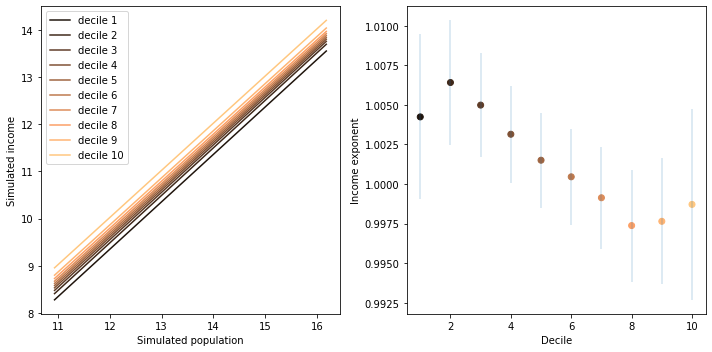

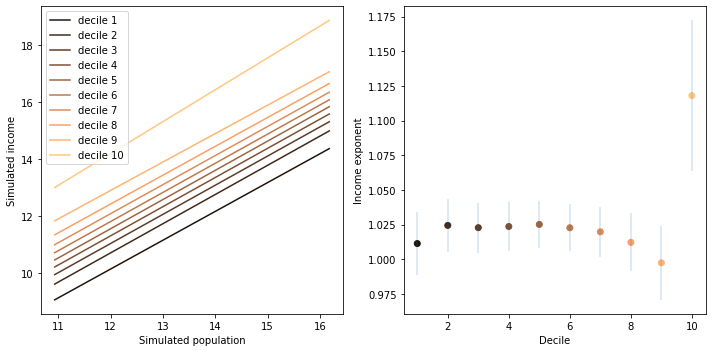

In [45]:
get_coefs(fakedf_realparams3_dec)
get_coefs(fakedf3_dec)

### Method 2
Shuffle MSAs.

In [20]:
msa_cts = ct_msa_key.groupby('msa').agg({'ct':pd.Series.nunique}).to_dict()['ct']

fake_ct_msa_key = {}
import copy
poss_cts = copy.deepcopy(list(ct_msa_key.ct.drop_duplicates()))
msas = ct_msa_key.msa.drop_duplicates()
random.shuffle(poss_cts)
i=0
for msa in msas:
    nct = msa_cts[msa]
    cts = poss_cts[i:i+nct]
    i = i+nct
    fake_ct_msa_key[msa] = cts
    
fake_key_df = pd.DataFrame(columns=['msa','ct'])
for msa in fake_ct_msa_key.keys():
    for ct in fake_ct_msa_key[msa]:
        fake_key_df=fake_key_df.append({'msa':msa,'ct':ct},ignore_index=True)


msadf = pd.merge(msa_pop,msa_income,on='msa')
ctdf = pd.merge(ct_pop,ct_income,left_on='ct',right_on='tractid_census').drop('tractid_census',axis=1)
fakectdf = pd.merge(ctdf, fake_key_df, on='ct')

fakectdf['total_workers'] = fakectdf['total_workers'].astype(float)
fakectdf['mean_dollars'] = fakectdf['mean_dollars'].astype(float)
fakectdf['total_dollars'] = fakectdf['total_dollars'].astype(float)
fakectdf['population'] = fakectdf['population'].astype(float)
msadf['workers'] = msadf['workers'].astype(float)
msadf['meandollars'] = msadf['meandollars'].astype(float)
msadf['totaldollars'] = msadf['totaldollars'].astype(float)
msadf['population'] = msadf['population'].astype(float)


fakectmsadf = pd.merge(fakectdf,msadf,on='msa').rename(columns={'mean_dollars':'ct_meandollars','meandollars':'msa_meandollars','population_x':'ct_population','population_y':'msa_population','total_dollars':'ct_totaldollars','totaldollars':'msa_totaldollars','total_workers':'ct_workers','workers':'msa_workers'})

fakemsadf_sum = fakectmsadf.groupby('msa').agg({'ct_population':'sum','ct_totaldollars':'sum'}).reset_index().rename(columns={'ct_population':'pop_sum','ct_totaldollars':'dollars_sum'})
fakectmsadf = fakectmsadf.merge(fakemsadf_sum,on='msa')

In [21]:
# sm.OLS(np.log(fakectmsadf.drop_duplicates('msa').dollars_sum),sm.add_constant(np.log(fakectmsadf.drop_duplicates('msa').pop_sum))).fit().summary()

In [22]:
fakedf_method2_dec = cut(fakectmsadf)

/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
  0%|          | 0/490 [00:00<?, ?it/s]/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

[[0.9845454899702635,
  1.0020570237639272,
  1.0012473565987385,
  1.0036672820505714,
  0.9986302220773113,
  1.0021476279288042,
  1.0027729921873774,
  1.003373831416583,
  1.0098568979815743,
  1.0335100788012235],
 const            10.257650
 ct_population     1.006475
 dtype: float64]

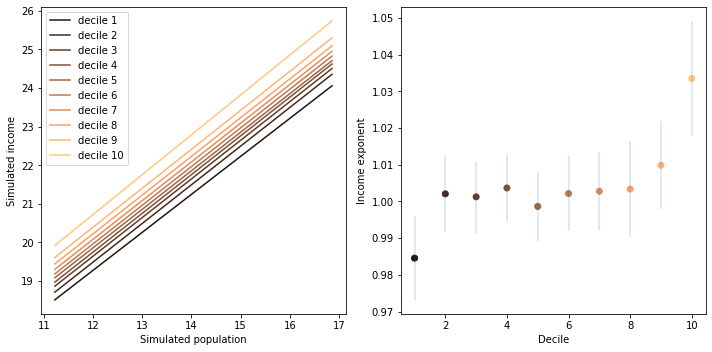

In [47]:
get_coefs(fakedf_method2_dec)

### Method 3
Shuffle down-selected CTs

In [24]:
msa_cts = ct_msa_key.groupby('msa').agg({'ct':pd.Series.nunique}).to_dict()['ct']

In [25]:
poss_cts=[]
log_bins = np.logspace(np.min(np.log(msadf.totaldollars)),np.max(np.log(msadf.totaldollars)),num=15,base=np.exp(1))
for i in range(len(log_bins)-1):
    binmax = log_bins[i+1]
    binmin = log_bins[i]
    binmsas = msadf[(msadf.totaldollars>=binmin) & (msadf.totaldollars<=binmax)].msa.drop_duplicates()#.ct.drop_duplicates()
    bincts = ctmsadf[ctmsadf.msa.isin(binmsas)].ct
    print(len(bincts))
    if len(bincts)>0:
        sampcts = random.choices(list(bincts),k=1500)
        for c in sampcts:
            poss_cts.append(c)

0
0
1561
4333
6975
5190
7090
8096
6024
8592
8442
9030
6592
0


In [26]:
fake_ct_msa_key = {}
import copy
random.shuffle(poss_cts)
i=0
for msa in msas:
    nct = msa_cts[msa]
    cts = random.sample(poss_cts,k=nct)
    i = i+nct
    fake_ct_msa_key[msa] = cts
    
fake_key_df = pd.DataFrame(columns=['msa','ct'])
for msa in fake_ct_msa_key.keys():
    for ct in fake_ct_msa_key[msa]:
        fake_key_df=fake_key_df.append({'msa':msa,'ct':ct},ignore_index=True)
        
msadf = pd.merge(msa_pop,msa_income,on='msa')
ctdf = pd.merge(ct_pop,ct_income,left_on='ct',right_on='tractid_census').drop('tractid_census',axis=1)
fakectdf = pd.merge(ctdf, fake_key_df, on='ct')

fakectdf['total_workers'] = fakectdf['total_workers'].astype(float)
fakectdf['mean_dollars'] = fakectdf['mean_dollars'].astype(float)
fakectdf['total_dollars'] = fakectdf['total_dollars'].astype(float)
fakectdf['population'] = fakectdf['population'].astype(float)
msadf['workers'] = msadf['workers'].astype(float)
msadf['meandollars'] = msadf['meandollars'].astype(float)
msadf['totaldollars'] = msadf['totaldollars'].astype(float)
msadf['population'] = msadf['population'].astype(float)


fakectmsadf = pd.merge(fakectdf,msadf,on='msa').rename(columns={'mean_dollars':'ct_meandollars','meandollars':'msa_meandollars','population_x':'ct_population','population_y':'msa_population','total_dollars':'ct_totaldollars','totaldollars':'msa_totaldollars','total_workers':'ct_workers','workers':'msa_workers'})

fakemsadf_sum = fakectmsadf.groupby('msa').agg({'ct_population':'sum','ct_totaldollars':'sum'}).reset_index().rename(columns={'ct_population':'pop_sum','ct_totaldollars':'dollars_sum'})
fakectmsadf = fakectmsadf.merge(fakemsadf_sum,on='msa')

In [27]:
fakedf_method3 = cut(fakectmsadf)

/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
  0%|          | 0/544 [00:00<?, ?it/s]/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/cateheine/Documents/SFI/sfi/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

[[0.9941651471422904,
  1.004274259357198,
  1.0042216632118683,
  1.004234601573924,
  1.0073009156886603,
  1.007946342276305,
  1.003918091669699,
  1.0011604865370036,
  1.0022675500381903,
  1.0181354939042806],
 const            10.209416
 ct_population     1.003844
 dtype: float64]

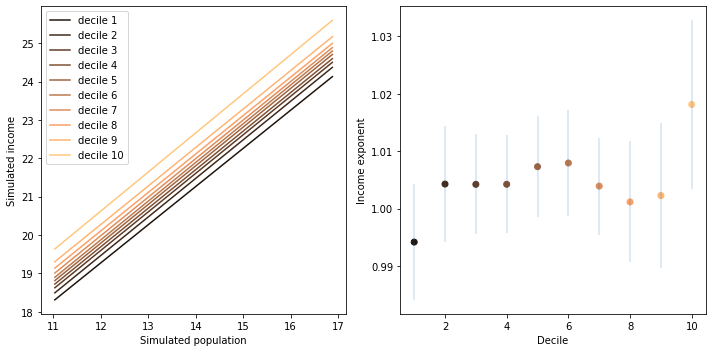

In [46]:
get_coefs(fakedf_method3)